# Memory Footprint

## Analyze STAR Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tk

In [2]:
build_bits  = [32, 64]
build_types = {'min': 'MinSizeRel',
               'rel': 'Release',
               'deb': 'RelWithDebInfo',
               'dic': 'Release-nodict'
              }
tk._prefix  = '/Users/dsmirnov/work/pub-data/star-32-vs-64-build'

In [3]:
builds_k = list(itertools.product(build_bits, build_types.keys()))
builds_v = list(itertools.product(build_bits, build_types.values()))

Build = collections.namedtuple('Build', ['id', 'bits', 'type', 'name'])

builds = [Build(f'{kk}{kb}', kb, kk, f'{vb}-{vt}') for (kb, kk), (vb, vt) in zip(builds_k, builds_v)]
builds

[Build(id='min32', bits=32, type='min', name='32-MinSizeRel'),
 Build(id='rel32', bits=32, type='rel', name='32-Release'),
 Build(id='deb32', bits=32, type='deb', name='32-RelWithDebInfo'),
 Build(id='dic32', bits=32, type='dic', name='32-Release-nodict'),
 Build(id='min64', bits=64, type='min', name='64-MinSizeRel'),
 Build(id='rel64', bits=64, type='rel', name='64-Release'),
 Build(id='deb64', bits=64, type='deb', name='64-RelWithDebInfo'),
 Build(id='dic64', bits=64, type='dic', name='64-Release-nodict')]

In [4]:
def id_to_name(ids):
    if isinstance(ids, str):
        for b in builds:
            if b.id==ids: return b.name
        return 'NotFound'
    else:
        return [b.name for b in builds if b.id in ids]

In [5]:
#id_to_name('min32')
#id_to_name(['rel32', 'min64', 'rel64'])

In [6]:
libpaths = {b.id: tk.get_libpath(b) for b in builds}
logfiles = {b.id: tk.get_log(b) for b in builds}

In [7]:
libfiles = {}

for b in builds:
    for _, _, libfiles[b.id] in os.walk(libpaths[b.id]): break

In [8]:
#libfiles['rel32'] == libfiles['min32'], libfiles['rel64'] == libfiles['min64']
#libfiles['rel32'], libfiles['min32']

In [9]:
len(libfiles['rel32'])

231

In [10]:
libinfo = []

for libfile in libfiles['rel32']:
    libsizes = [os.path.getsize(libpath+libfile) for libpath in libpaths.values()]
    libinfo.append( (libfile, *libsizes) )

In [11]:
df_libs = pd.DataFrame(libinfo, columns=['name']+[b.id for b in builds])
df_libs

,name,min32,rel32,deb32,dic32,min64,rel64,deb64,dic64
0,libctf_Tables.so,351444,397544,1555560,397688,424592,437176,1802312,437144
1,libemc_Tables.so,1181868,1338220,5351548,1338732,1421928,1473192,6224440,1473064
2,libftpc_Tables.so,173336,192376,722980,192440,210912,217328,840216,217312
3,libgcalor.a,619856,672768,1884636,672768,1055080,1121472,3230424,1121144
4,libgeant321.a,5132008,5650948,13155212,5650956,8551320,9177792,22073952,9174960
5,libgen_Tables.so,209708,232616,887536,232696,252760,258872,1029152,258856
6,libgeometry.so,13424,6477688,9965232,6498168,15016,19112,10593176,6169872
7,libgeometry_Tables.so,145808,161172,578220,161220,173816,180744,667768,180728
8,libglobal_Tables.so,607560,692084,2727148,692340,735424,761288,3166024,761224
9,libRTS.so,5378524,5535036,8014008,5535036,5439392,5550536,8667568,5534152


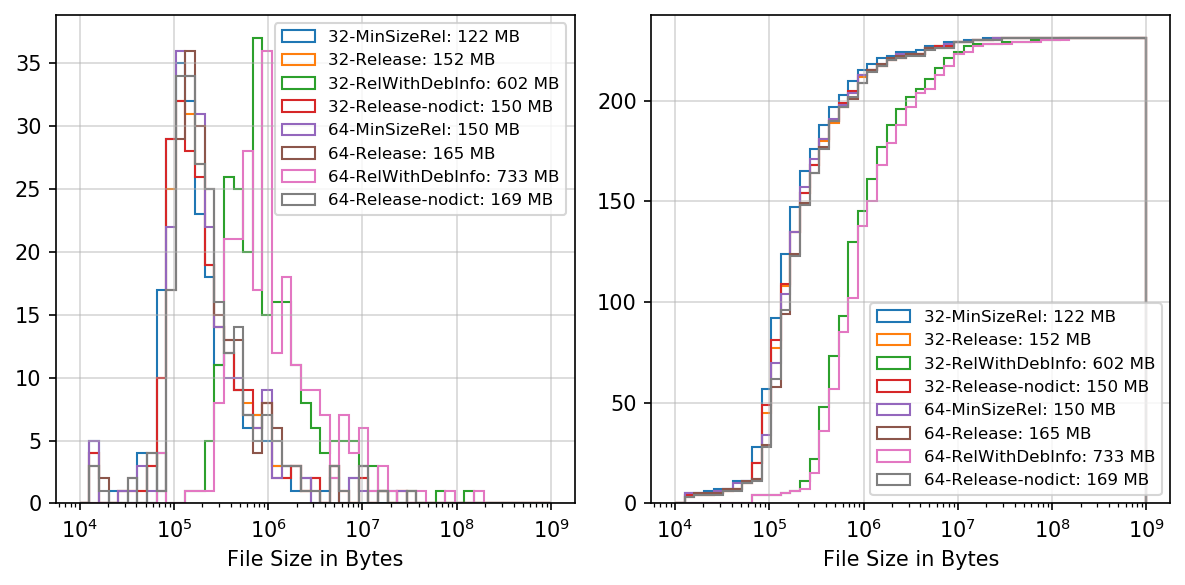

In [12]:
bins = np.logspace(4, 9, 50)
hist_kwargs = dict(bins=bins, histtype='step', lw=1)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

ax = axs[0]
for b in builds:
    data = df_libs[b.id]
    label = f'{b.name}: {data.sum()/1024/1024:.0f} MB'
    ax.hist(data, label=label, **hist_kwargs, cumulative=False)
ax.legend(prop={'size': 8})

ax = axs[1]
for b in builds:
    data = df_libs[b.id]
    label = f'{b.name}: {data.sum()/1024/1024:.0f} MB'
    ax.hist(data, label=label, **hist_kwargs, cumulative=True)
ax.legend(loc='lower right', prop={'size': 8})
    
for ax in np.ravel(axs):
    ax.semilogx(), ax.grid()
    ax.set_xlabel('File Size in Bytes')

plt.tight_layout()
plt.savefig('graphics/memory_lib_file_sizes.svg')

In [13]:
df_libs_sorted = df_libs.sort_values('min32', ascending=False, inplace=False)
#df_libs_sorted

In [14]:
select = df_libs_sorted.index[:20]
#select

datax = df_libs_sorted.loc[select]
#datax

## Release vs RelWithDebInfo

In [15]:
value_vars = [b.id for b in builds if b.id.startswith(('rel', 'deb'))]
value_vars

['rel32', 'deb32', 'rel64', 'deb64']

In [16]:
datax2 = datax.melt(id_vars='name', value_vars=value_vars)
#datax2

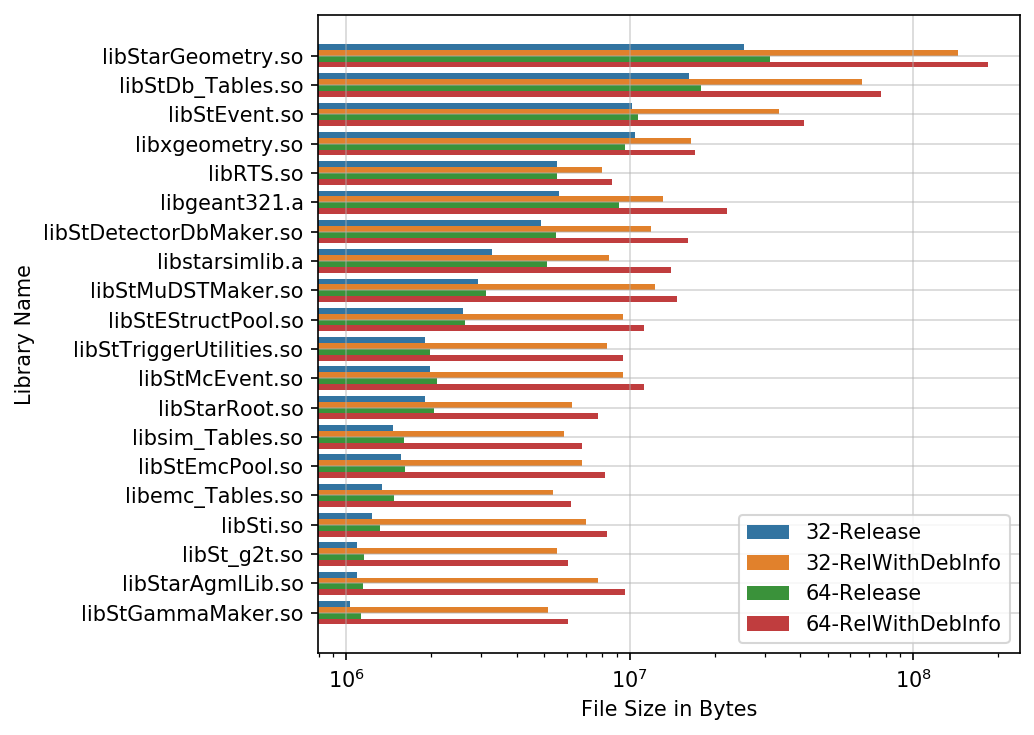

In [17]:
fig = plt.figure(figsize=(7,5))
ax = sns.barplot(y='name', x='value', hue='variable', data=datax2)
ax.legend(ax.legend().get_patches(), id_to_name(value_vars))
ax.set(xlabel='File Size in Bytes', ylabel='Library Name')
ax.semilogx();
ax.grid()
plt.tight_layout()
plt.savefig('graphics/memory_lib_file_sizes_top20.svg')

## Release vs RelWithDebInfo

In [18]:
value_vars = [b.id for b in builds if b.id.startswith(('rel', 'dic'))]
value_vars

['rel32', 'dic32', 'rel64', 'dic64']

In [19]:
datax2 = datax.melt(id_vars='name', value_vars=value_vars)
#datax2

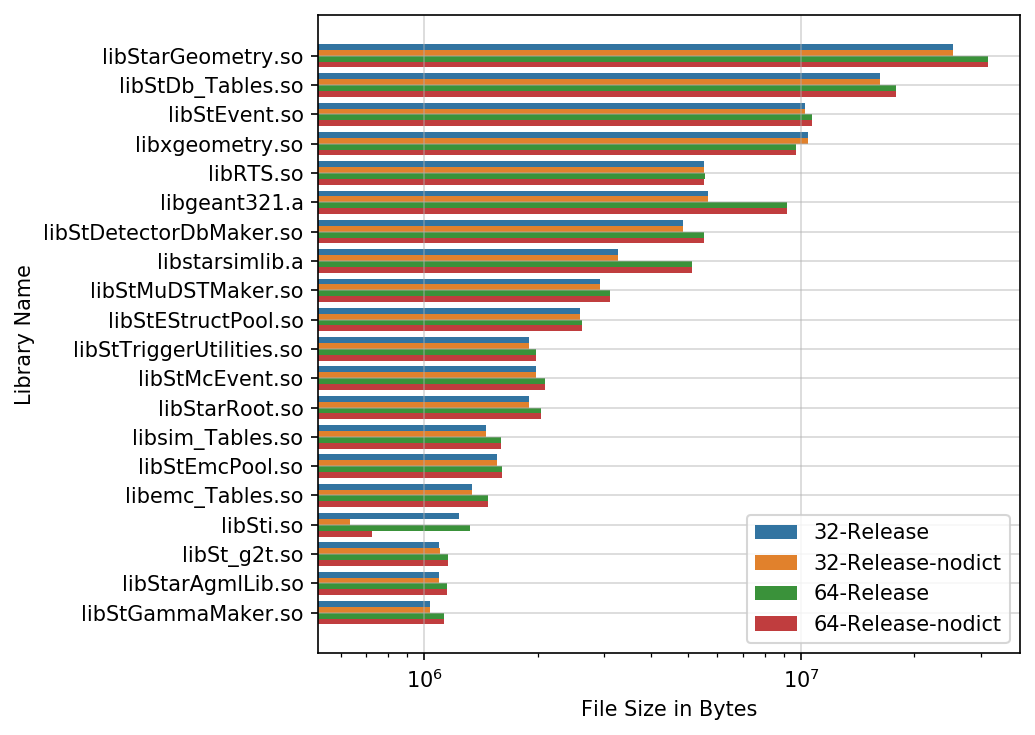

In [20]:
fig = plt.figure(figsize=(7,5))
ax = sns.barplot(y='name', x='value', hue='variable', data=datax2)
ax.legend(ax.legend().get_patches(), id_to_name(value_vars))
ax.set(xlabel='File Size in Bytes', ylabel='Library Name')
ax.semilogx();
ax.grid()
plt.tight_layout()
plt.savefig('graphics/memory_lib_file_sizes_top20_nodict.svg')

## Results from /proc/PID/status files

In [21]:
memfiles = {b.id: tk.get_proc(b) for b in builds}

In [22]:
dfs = {}
for bid, memfile in memfiles.items():
    if not os.path.isfile(memfile): continue
    dfs[bid] = pd.read_csv(memfile, skipinitialspace=True)

In [23]:
df = pd.concat(dfs.values(), keys=dfs.keys(), names=['id'])

In [24]:
df.reset_index(level=0, inplace=True)

In [25]:
df

,id,callerId,RssAnon,RssFile,RssShmem,VmHWM,VmLib,VmPeak,VmRSS,VmSize,VmSwap
0,min32,Construct:bfc,10.3516,17.7461,0,28.0977,60.6641,200.941,28.0977,200.938,0
1,min32,Load:libStarAgmlUtil,13.1719,18.0273,0,31.1992,60.6953,203.957,31.1992,203.953,0
2,min32,Load:libStarAgmlLib,13.2695,18.3672,0,31.6367,61.3320,204.621,31.6367,204.617,0
3,min32,Load:libGeometry,13.2891,18.3750,0,31.6641,61.3398,204.637,31.6641,204.633,0
4,min32,Load:libStarGeometry,14.8984,24.6953,0,39.5938,76.0391,220.977,39.5938,220.973,0
5,min32,Load:libStDb_Tables,16.4766,32.0234,0,48.5000,85.4883,231.887,48.5000,231.883,0
6,min32,Load:libemc_Tables,16.5977,32.6484,0,49.2461,86.2617,232.840,49.2461,232.836,0
7,min32,Load:libgeometry_Tables,16.6172,32.7266,0,49.3438,86.3555,232.945,49.3438,232.941,0
8,min32,Load:libglobal_Tables,16.6797,33.0352,0,49.7148,86.7578,233.375,49.7148,233.371,0
9,min32,Load:libsim_Tables,16.8477,33.6914,0,50.5391,87.6016,234.445,50.5391,234.441,0


In [26]:
len(dfs['rel32']), len(dfs['rel64']), len(dfs['deb32']), len(dfs['deb64'])

(381, 381, 381, 381)

In [27]:
def make_fig(data, figname, title='', labelsize=10):
    fig = plt.figure(figsize=(7,5))
    ax = sns.pointplot(x='callerId', y='VmSize', hue='id', data=data, markers='x',scale=0.8)#, palette=['C0', 'C0'])
    ax = sns.pointplot(x='callerId', y='VmRSS', hue='id', data=data, markers='.', scale=0.8)#, palette=['C1', 'C1'])
    ax = sns.pointplot(x='callerId', y='VmLib', hue='id', data=data, markers='+', scale=0.8)#, palette=['C2', 'C2'])
    ax.tick_params(axis='x', labelrotation=90, labelsize=labelsize)
    ax.grid()
    ax.set_ylim(bottom=0)
    ax.set(title=title, xlabel='', ylabel='Memory Usage, MB');
    #[t.set_text(id_to_name(t.get_text())) for t in ax.legend().get_texts()]
    ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig('graphics/'+figname+'.svg')

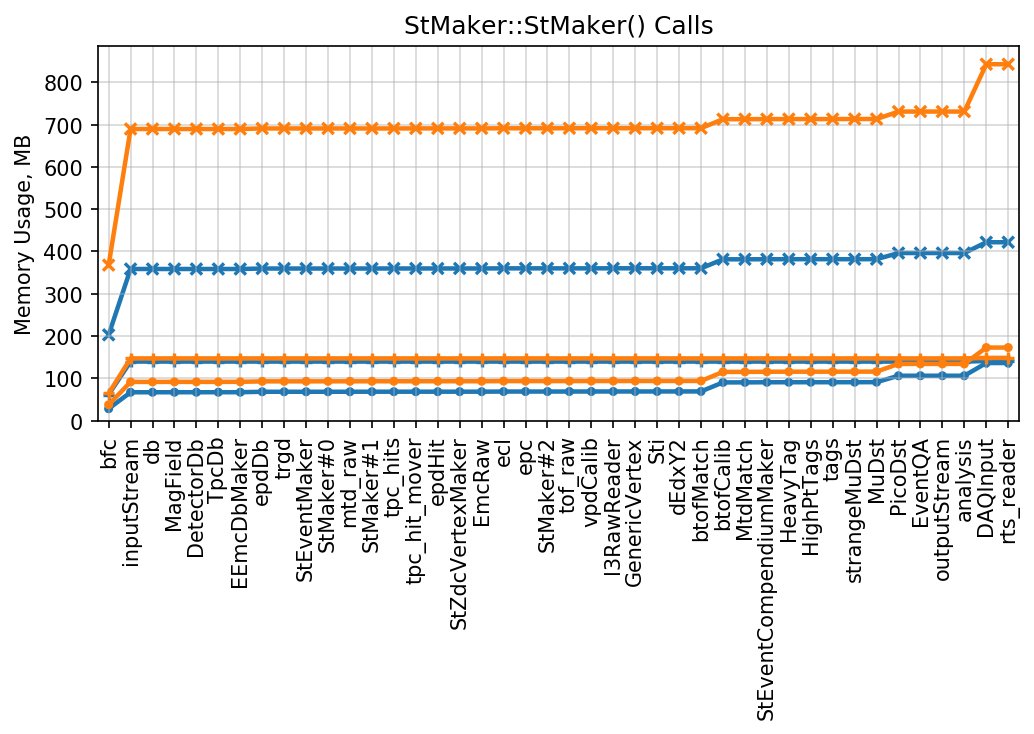

In [28]:
select = df.callerId.str.contains('Construct:') & df.id.str.contains('rel')
data = df.loc[select].copy()
data.callerId = data.callerId.str.replace('Construct:', '')
make_fig(data, 'memory_calls_constructor_rel', 'StMaker::StMaker() Calls')

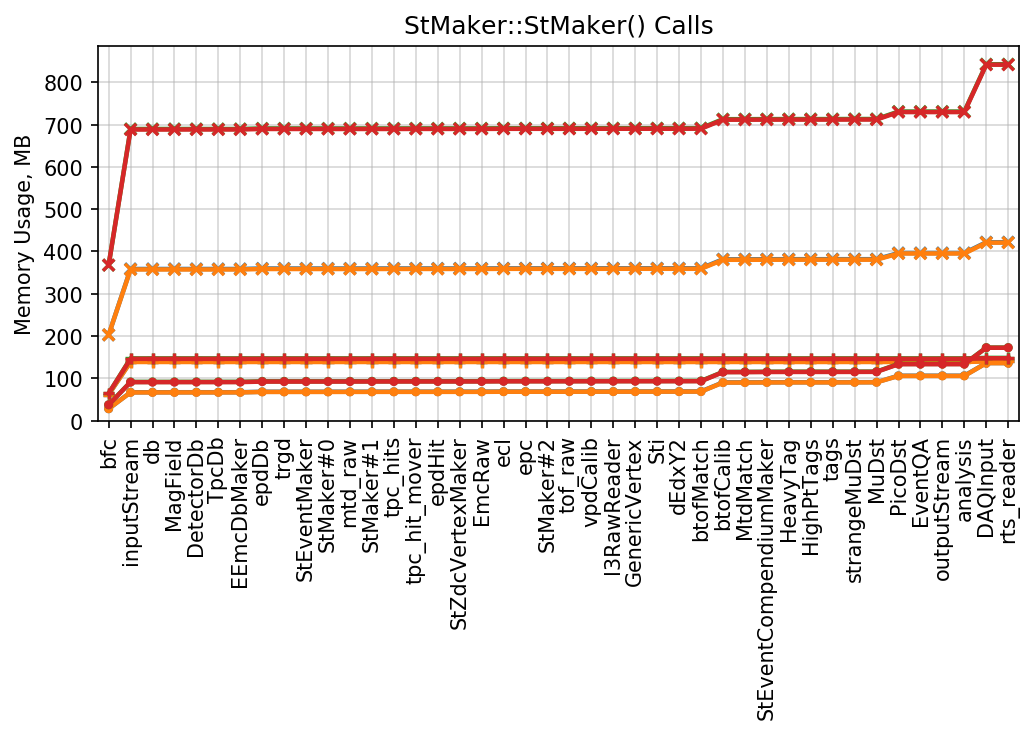

In [29]:
select = df.callerId.str.contains('Construct') & (df.id.str.contains('rel')|df.id.str.contains('dic'))
data = df.loc[select].copy()
data.callerId = data.callerId.str.replace('Construct:', '')
make_fig(data, 'memory_calls_constructor_rel_dic', 'StMaker::StMaker() Calls')

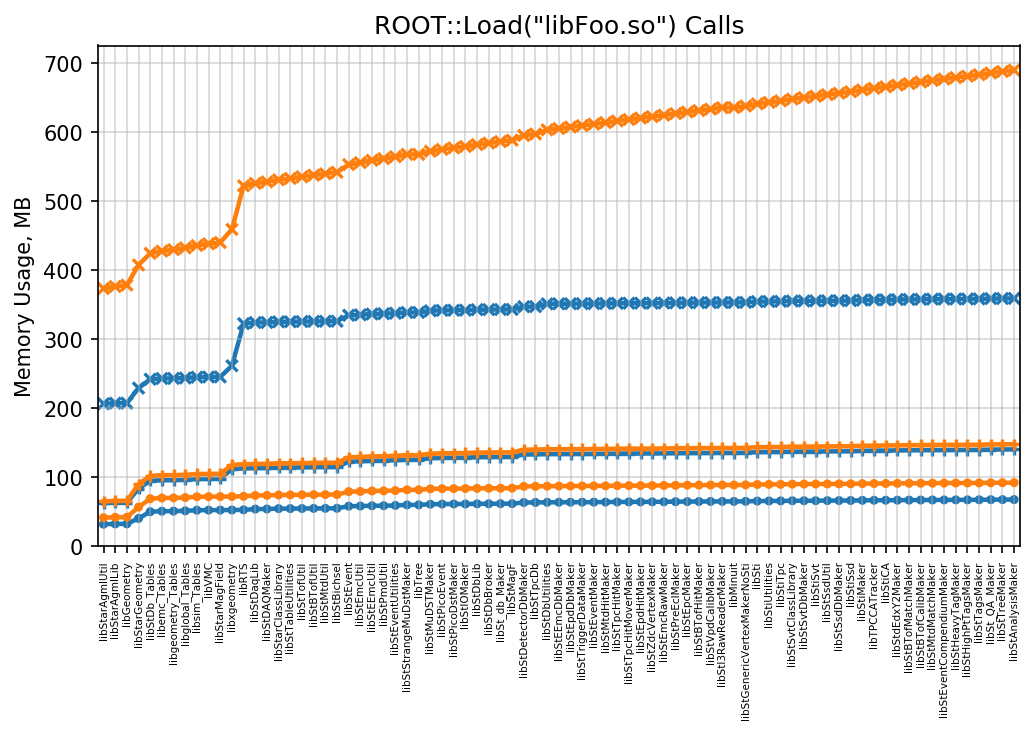

In [30]:
select = df.callerId.str.contains('Load:') & (df.id.str.contains('rel'))
#select = df.callerId.str.contains('Load:') & (df.id.str.contains('rel')|df.id.str.contains('dic'))
data = df.loc[select].copy()
data.callerId = data.callerId.str.replace('Load:', '')
make_fig(data, 'memory_calls_load', 'ROOT::Load(\"libFoo.so\") Calls', 5)
#make_fig(data, 'memory_calls_load_rel_dic', 'ROOT::Load(\"libFoo.so\") Calls', 5)

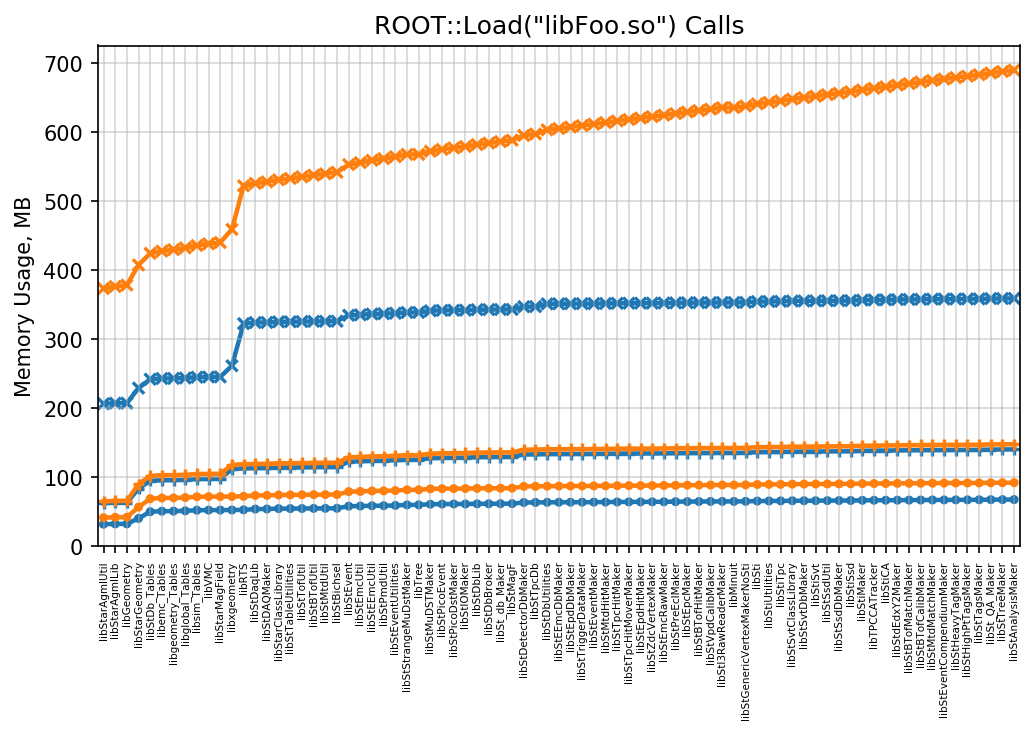

In [31]:
select = df.callerId.str.contains('Load:') & (df.id.str.contains('rel'))
#select = df.callerId.str.contains('Load:') & (df.id.str.contains('rel')|df.id.str.contains('dic'))
data = df.loc[select].copy()
data.callerId = data.callerId.str.replace('Load:', '')
make_fig(data, 'memory_calls_load', 'ROOT::Load(\"libFoo.so\") Calls', 5)
#make_fig(data, 'memory_calls_load_rel_dic', 'ROOT::Load(\"libFoo.so\") Calls', 5)

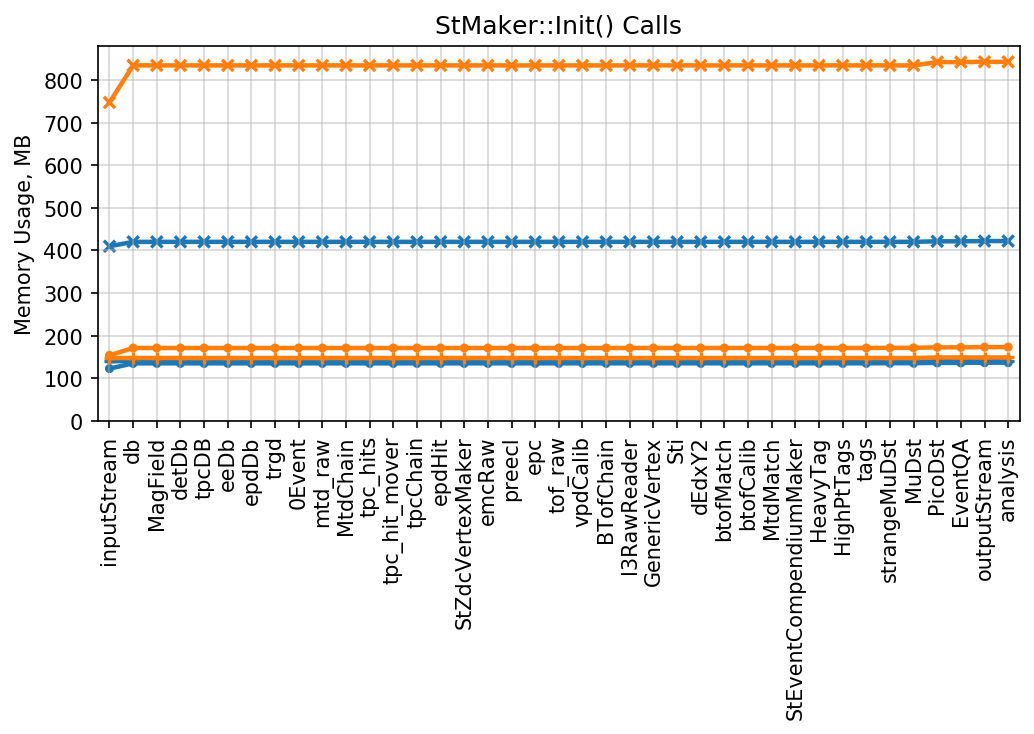

In [32]:
select = df.callerId.str.contains('Init:') & df.id.str.contains('rel')
data = df.loc[select].copy()
data.callerId = data.callerId.str.replace('Init:', '')
make_fig(data, 'memory_calls_init', 'StMaker::Init() Calls')

In [33]:
def call_indices(df):
    load = [df.index[  (df.callerId.str.contains('Load:')) ][0]]
    con  =  df.index[  (df.callerId.str.contains('Construct:inputStream')) ]
    ini  =  df.index[  (df.callerId.str.contains('Init:inputStream')) ]
    clr  =  df.index[  (df.callerId.str.contains('Clear:analysis')) ]
    evt  =  df.index[  (df.callerId.str.contains('EndMaker:inputStream')) ]
    return  load, con, ini, clr, evt

In [34]:
idx_load, idx_con, idx_ini, idx_clr, idx_evt = call_indices(dfs['rel32'])

In [35]:
def plot_vertical_lines(indices, color):
    for idx in indices:
        plt.plot([idx, idx], plt.ylim(), f'{color}')

In [36]:
xticks_ = np.sort(idx_load + idx_con.tolist() + idx_ini.tolist() + idx_clr.tolist() + idx_evt.tolist())
xlabels_ = ['$\\longrightarrow$\nLoad Libs', '$\\longrightarrow$\nConstr.',
            '$\\longrightarrow$\nInit()',
            '$\\longrightarrow$\nClear()\n#1', '$\\longrightarrow$\nMake()',
            '$\\longrightarrow$\nClear()\n#2', '$\\longrightarrow$\nMake()',
            '$\\longrightarrow$\nClear()\n#3', '$\\longrightarrow$\nMake()']

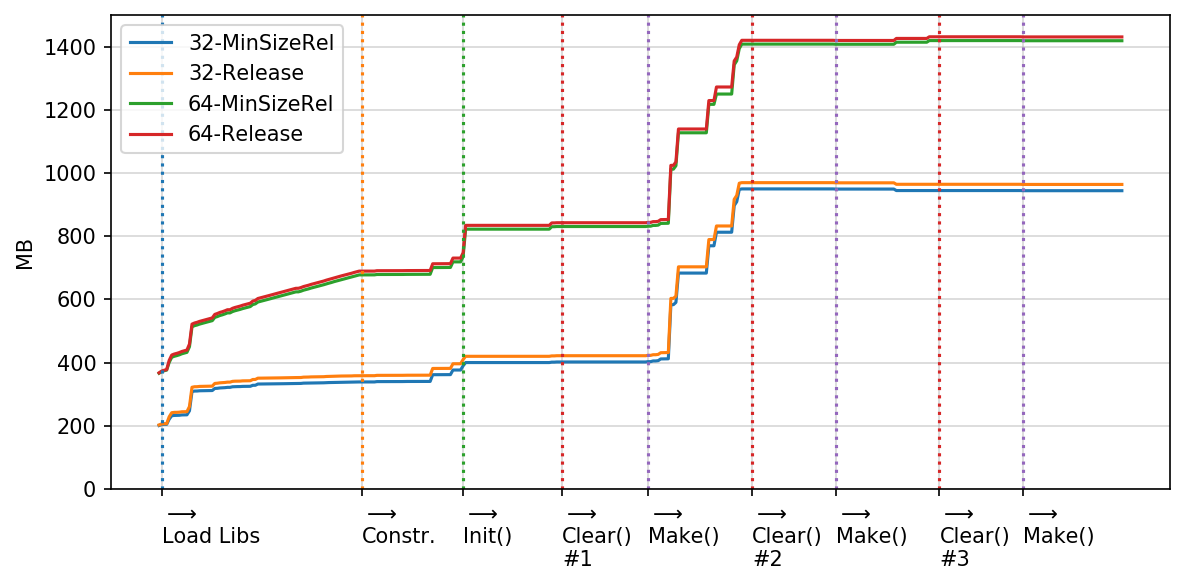

In [37]:
fig = plt.figure( figsize=(8,4))

for b in builds:
    if b.id.startswith(('deb', 'dic')): continue
    data = dfs[b.id].VmSize
    plt.plot(np.arange(len(data)), data, label=b.name)

plt.ylim(bottom=0, top=1500)

plot_vertical_lines(idx_load, 'C0:')
plot_vertical_lines(idx_con, 'C1:')
plot_vertical_lines(idx_ini, 'C2:')
plot_vertical_lines(idx_clr, 'C3:')
plot_vertical_lines(idx_evt, 'C4:')

plt.xticks(xticks_, xlabels_, ha='left', size=10)
plt.legend()
plt.grid()
plt.gca().set(ylabel='MB')
plt.tight_layout()
plt.savefig('graphics/memory_calls_overall.svg')


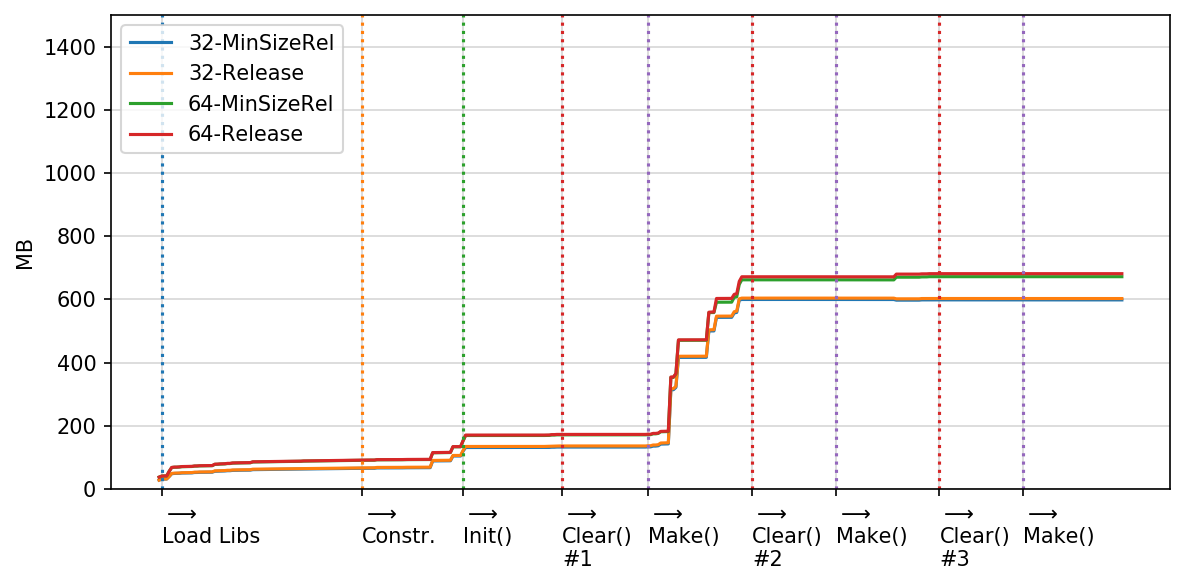

In [38]:
fig = plt.figure( figsize=(8,4))

for b in builds:
    if b.id.startswith(('deb', 'dic')): continue
    data = dfs[b.id].VmRSS
    plt.plot(np.arange(len(data)), data, label=b.name)

plt.ylim(bottom=0, top=1500)

plot_vertical_lines(idx_load, 'C0:')
plot_vertical_lines(idx_con, 'C1:')
plot_vertical_lines(idx_ini, 'C2:')
plot_vertical_lines(idx_clr, 'C3:')
plot_vertical_lines(idx_evt, 'C4:')

plt.xticks(xticks_, xlabels_, ha='left', size=10)
plt.legend()
plt.grid()
plt.gca().set(ylabel='MB')
plt.tight_layout()
plt.savefig('graphics/memory_calls_overall.svg')


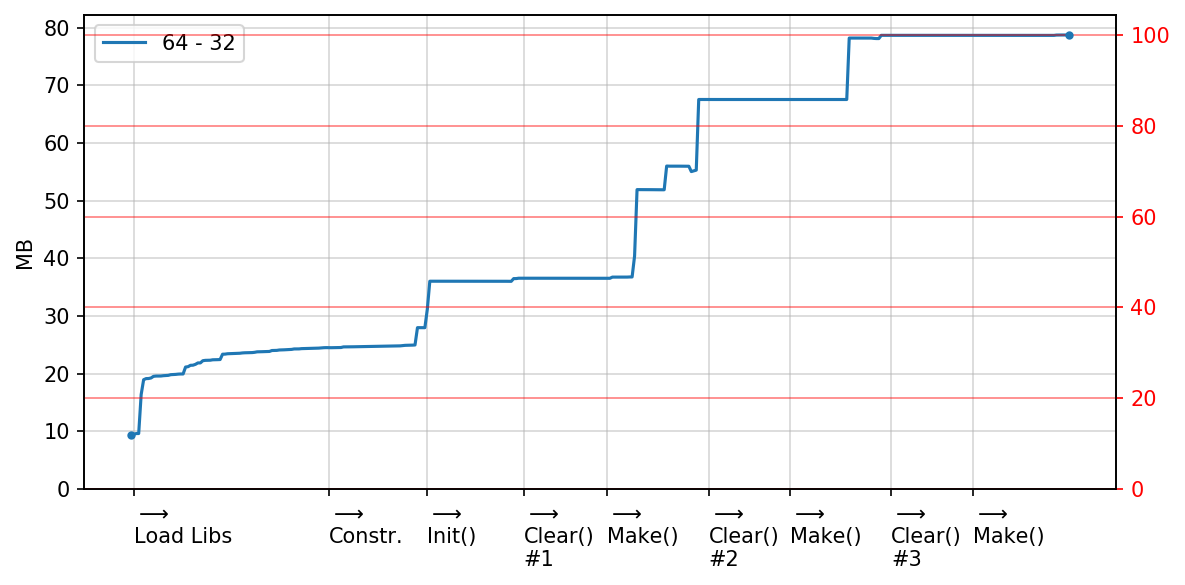

In [39]:
fig = plt.figure(figsize=(8,4))

data32 = dfs['rel32'].VmRSS.values
data64 = dfs['rel64'].VmRSS.values
delta = data64-data32
plt.plot(np.arange(len(data32)), delta, label='64 - 32')
plt.ylim(bottom=0)
plt.gca().set(ylabel='MB')
plt.legend()
plt.grid(True)
plt.xticks(xticks_, xlabels_, ha='left', size=10)

plt.twinx()

plt.plot([0,len(delta)-1], [delta[0]/np.max(delta)*100, delta[-1]/np.max(delta)*100], '.', label='64 - 32')
plt.gca().tick_params('y', colors='r')
plt.grid(color='r')

plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('graphics/memory_calls_diff.svg')


In [40]:
#fig = plt.figure( figsize=(8,4))
#
#for b in builds:
#    data = dfs[b.id].heap
#    plt.plot(np.arange(len(data)), data, label=b.name)
#
#plt.ylim(bottom=0)
#
#plt.legend()
#plt.grid()
#plt.gca().set(xlabel='MemStat Call', ylabel='Mb')
#plt.tight_layout()

## Statistical Analysis of ELF files

In [41]:
#import cxxfilt
from elftools.elf.elffile import ELFFile

In [42]:
from elftools.construct import Container
from pandas.io.json import json_normalize


def todict(dict_with_container):
    mydict = {}
    for key, value in dict_with_container.items():
        if isinstance(value, Container):
            mydict[key] = todict(value.__dict__)
        else:
            mydict[key] = value
    return mydict


def symbol_to_dict(sym):
    try:
        return dict(name=cxxfilt.demangle(sym.name), entry=todict(sym.entry), cf=True)
    except:
        return dict(name=sym.name, entry=todict(sym.entry), cf=False)

    
def make_sym_df(libfull):
    with open(libfull, 'rb') as f:
        try:
            elffile = ELFFile(f)
            symbols = [sym for sym in elffile.get_section_by_name('.symtab').iter_symbols()]
            symbols_list = [symbol_to_dict(symbol) for symbol in symbols]
            df = pd.DataFrame(json_normalize(symbols_list, sep='_'))
            isrootgen = df.name.str.contains('_dictLN_|_dict_|ROOTDict|G__')
            df = df.assign(r=isrootgen)
            return df
        except:
            return None

    
def calc_stats(df):
    # Calculate fraction of c++filt failed
    frac_failed_cppfilt = float(np.count_nonzero(df.cf))/len(df.cf)

    total_st_size  = df.entry_st_size.sum()
    root_st_size   = df.loc[df.r].entry_st_size.sum()
    frac_root_size = float(root_st_size)/total_st_size
    frac_root_numb = float(np.count_nonzero(df.r))/len(df.r)
    
    return dict(size_st=total_st_size,
                #frac_cf=frac_failed_cppfilt,
                frac_rs=frac_root_size,
                frac_rn=frac_root_numb
               )


def make_stats_dict(build, libfile):
    libfull = tk.get_libpath(build) + libfile
    df = make_sym_df(libfull)
    if df is None: return None
    stats = calc_stats(df)
    size = os.path.getsize(libfull)
    return dict(size=size, **stats)

### All Libaries Statistics

In [43]:
libstats = []

libfiles_selected = [lf for lf in libfiles['rel32'] if '.so' in lf]
#libfiles_selected = [lf for lf in libfiles_selected if any(s in lf for s in ['RTS', 'Sti', 'StEvent', 'Db', 'db'])]
libfiles_selected = [lf for lf in libfiles_selected if any(s in lf for s in ['RTS', 'Sti', 'StEvent'])]
libfiles_selected

['libRTS.so',
 'libStEvent.so',
 'libStEventCompendiumMaker.so',
 'libStEventMaker.so',
 'libStEventUtilities.so',
 'libStGenericVertexMakerNoSti.so',
 'libSti.so',
 'libStiCA.so',
 'libStiIst.so',
 'libStiMaker.so',
 'libStiPxl.so',
 'libStiRnD.so',
 'libStiSsd.so',
 'libStiSvt.so',
 'libStiTpc.so',
 'libStiUtilities.so']

In [44]:
for idx, libfile in enumerate(libfiles_selected):
    print(f'{idx:3d} processing {libfile}')
    
    for b in builds:
        #if 'rel' not in b.id: continue
        if 'deb' in b.id: continue
        libstat = make_stats_dict(b, libfile)
        if libstat is None:
            print('^^^ skipping...')
            break
        libstats.append( dict(name=libfile, bid=b.id, **libstat) )

#import pprint
#pprint.pprint(libstats)

  0 processing libRTS.so
  1 processing libStEvent.so
  2 processing libStEventCompendiumMaker.so
  3 processing libStEventMaker.so
  4 processing libStEventUtilities.so
  5 processing libStGenericVertexMakerNoSti.so
  6 processing libSti.so
  7 processing libStiCA.so
  8 processing libStiIst.so
  9 processing libStiMaker.so
 10 processing libStiPxl.so
 11 processing libStiRnD.so
 12 processing libStiSsd.so
 13 processing libStiSvt.so
 14 processing libStiTpc.so
 15 processing libStiUtilities.so


In [45]:
df = pd.DataFrame(json_normalize(libstats, sep='_'))

In [46]:
df

,name,bid,size,size_st,frac_rs,frac_rn
0,libRTS.so,min32,5378524,63552139,0.000013,0.014980
1,libRTS.so,rel32,5535036,63670584,0.000016,0.012736
2,libRTS.so,dic32,5535036,63670584,0.000016,0.012736
3,libRTS.so,min64,5439392,63561281,0.000011,0.015370
4,libRTS.so,rel64,5550536,63650905,0.000012,0.015385
5,libRTS.so,dic64,5534152,63650905,0.000012,0.015385
6,libStEvent.so,min32,8270624,3475991,0.719584,0.533661
7,libStEvent.so,rel32,10234444,5290411,0.786988,0.542278
8,libStEvent.so,dic32,10238140,5290411,0.786988,0.542278
9,libStEvent.so,min64,9807096,4125368,0.777492,0.537043


In [47]:
select = df.bid.str.contains('rel') |df.bid.str.contains('dic') 
data = df.loc[select]

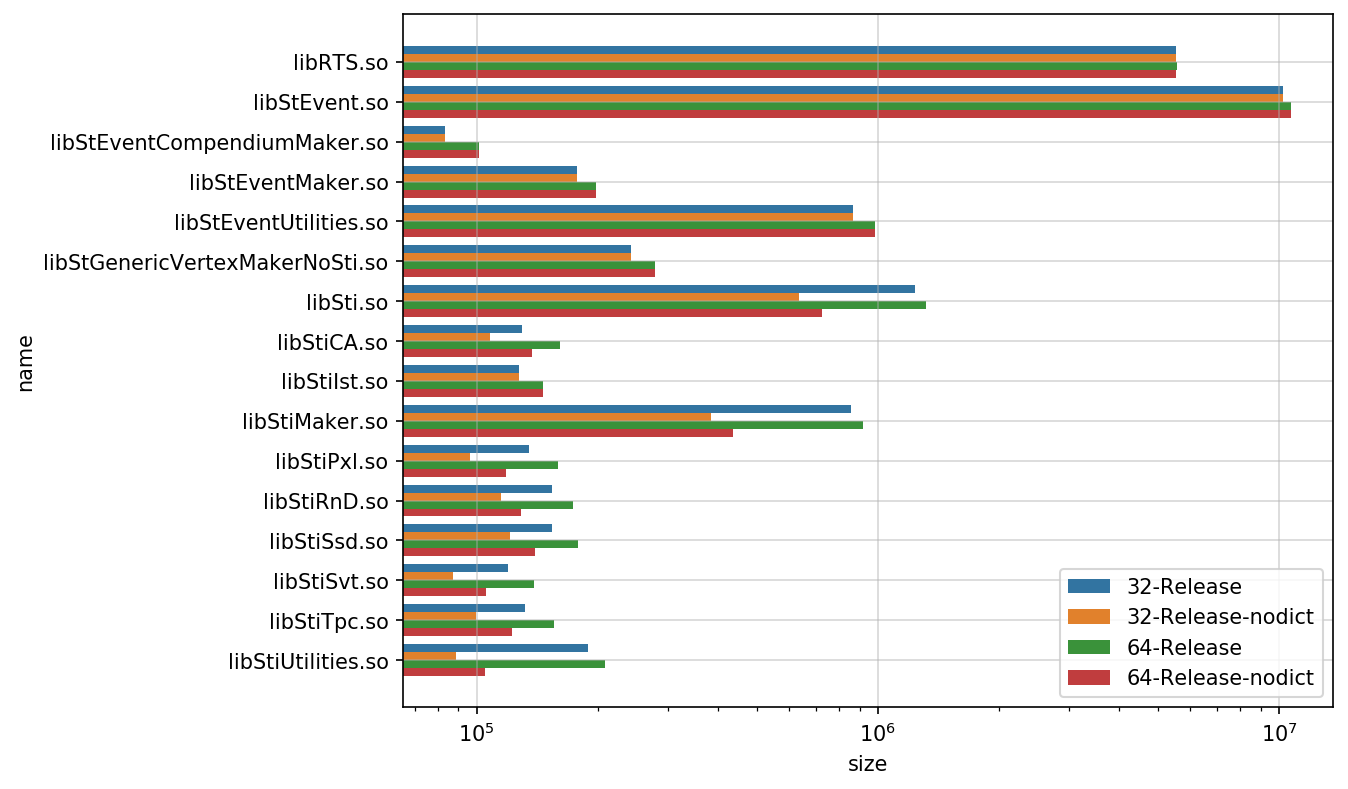

In [48]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x='size', y='name', hue='bid', data=data)
ax.semilogx()
ax.grid()
_ = [t.set_text(id_to_name(t.get_text())) for t in ax.legend().get_texts()]
plt.savefig('graphics/memory_select_elf_size.svg')

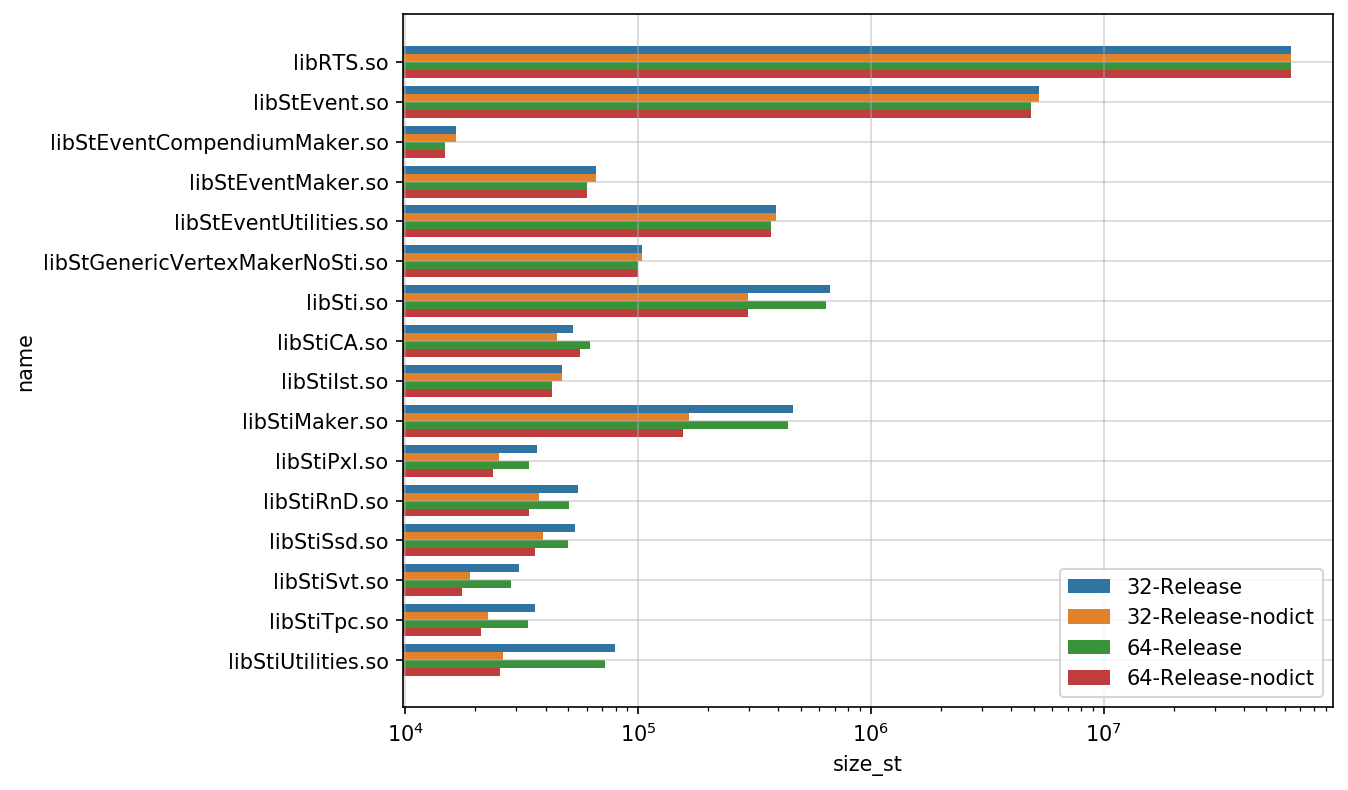

In [49]:
fig = plt.figure(figsize=(8,6))
#ax = sns.barplot(x=data['size_st']/data['size'], y='name', hue='bid', data=data)
ax = sns.barplot(x='size_st', y='name', hue='bid', data=data)
ax.semilogx()
ax.grid()
_ = [t.set_text(id_to_name(t.get_text())) for t in ax.legend().get_texts()]
plt.savefig('graphics/memory_select_elf_size_st.svg')

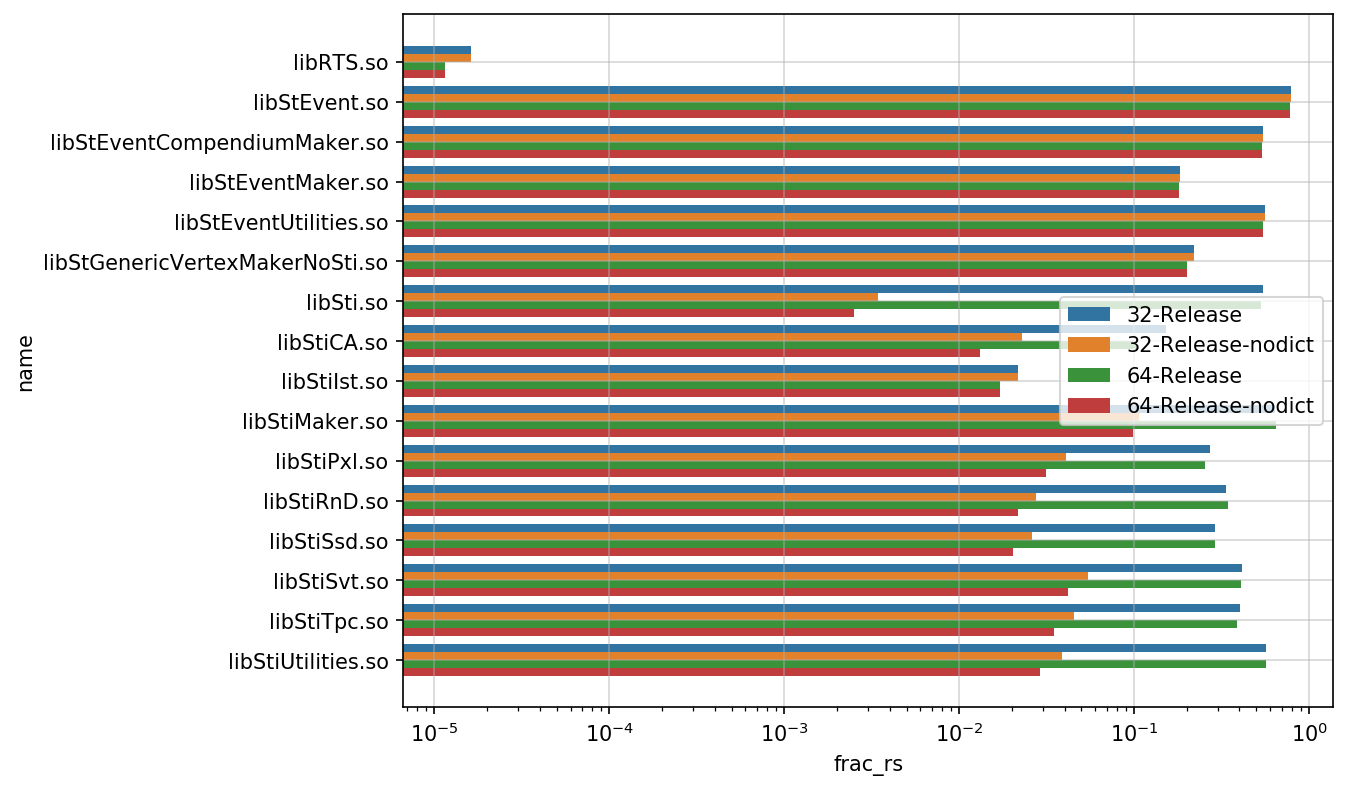

In [50]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(y='name', x='frac_rs', hue='bid', data=data)
ax.semilogx()
ax.grid()
_ = [t.set_text(id_to_name(t.get_text())) for t in ax.legend().get_texts()]
plt.savefig('graphics/memory_select_elf_frac_rs.svg')

### Detailed View of Select Libraries

In [51]:
libname = 'libSti.so'
#libname = 'libStEvent.so'

In [52]:
df = make_sym_df(libpaths['rel32']+libname)

In [53]:
df

,name,cf,entry_st_name,entry_st_value,entry_st_size,entry_st_info_bind,entry_st_info_type,entry_st_other_visibility,entry_st_shndx,r
0,,False,0,0,0,STB_LOCAL,STT_NOTYPE,STV_DEFAULT,SHN_UNDEF,False
1,,False,0,276,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,1,False
2,,False,0,312,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,2,False
3,,False,0,13636,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,3,False
4,,False,0,49780,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,4,False
5,,False,0,131762,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,5,False
6,,False,0,136280,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,6,False
7,,False,0,136488,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,7,False
8,,False,0,159904,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,8,False
9,,False,0,166120,0,STB_LOCAL,STT_SECTION,STV_DEFAULT,9,False


In [54]:
plt.hist(df32.entry_st_size, label='32', bins=np.logspace(0, 5, 101), histtype='step')
plt.hist(df32t.entry_st_size, label='32t', bins=np.logspace(0, 5, 101), histtype='step')
plt.hist(df64.entry_st_size, label='64', bins=np.logspace(0, 5, 101), histtype='step')
plt.semilogx()
#plt.semilogy()
plt.grid()
plt.legend()

NameError: name 'df32' is not defined

In [ ]:
bins = np.logspace(0, 5, 101)
plt.hist(df32.entry_st_size,  label='32',  bins=bins, histtype='step', cumulative=True)
plt.hist(df32t.entry_st_size, label='32t', bins=bins, histtype='step', cumulative=True)
plt.hist(df64.entry_st_size,  label='64',  bins=bins, histtype='step', cumulative=True)
plt.semilogx()
plt.grid()
plt.legend(loc='lower center')

In [ ]:
def select_symbols(df):
    sel_fnc = df.entry_st_info_type == 'STT_FUNC'
    sel_obj = df.entry_st_info_type == 'STT_OBJECT'
    sel_w = df.entry_st_info_bind == 'STB_WEAK'
    sel_g = df.entry_st_info_bind == 'STB_GLOBAL'
    sel_l = df.entry_st_info_bind == 'STB_LOCAL'
    return  sel_fnc, sel_obj, sel_w, sel_g, sel_l

In [ ]:
#df.loc[sel_l]

In [ ]:
def select_symbol_sizes(df):
    sel_fnc, sel_obj, sel_w, sel_g, sel_l = select_symbols(df)
    f  = df.loc[sel_fnc].entry_st_size
    o  = df.loc[sel_obj].entry_st_size
    
    fl = df.loc[sel_fnc&sel_l].entry_st_size
    fg = df.loc[sel_fnc&sel_g].entry_st_size
    fw = df.loc[sel_fnc&sel_w].entry_st_size
    
    flr = df.loc[sel_fnc&sel_l&df.r].entry_st_size
    fgr = df.loc[sel_fnc&sel_g&df.r].entry_st_size
    fwr = df.loc[sel_fnc&sel_w&df.r].entry_st_size
    
    ol = df.loc[sel_obj&sel_l].entry_st_size
    og = df.loc[sel_obj&sel_g].entry_st_size
    ow = df.loc[sel_obj&sel_w].entry_st_size
    
    olr = df.loc[sel_obj&sel_l&df.r].entry_st_size
    ogr = df.loc[sel_obj&sel_g&df.r].entry_st_size
    owr = df.loc[sel_obj&sel_w&df.r].entry_st_size
    
    return f, o, fl, fg, fw, flr, fgr, fwr, ol, og, ow, olr, ogr, owr

In [ ]:
f32, o32, fl32, fg32, fw32, fl32r, fg32r, fw32r, ol32, og32, ow32, ol32r, og32r, ow32r = select_symbol_sizes(df32)
f32t, o32t, fl32t, fg32t, fw32t, fl32rt, fg32rt, fw32rt, ol32t, og32t, ow32t, ol32rt, og32rt, ow32rt = select_symbol_sizes(df32t)
f64, o64, fl64, fg64, fw64, fl64r, fg64r, fw64r, ol64, og64, ow64, ol64r, og64r, ow64r = select_symbol_sizes(df64)

In [ ]:
def change_in_size(s32, s64):
    change = (s64.sum() - s32.sum())/s32.sum()*100
    return f'Total Size 32: {s32.sum()/1024/1024:.2f}Mb\nTotal Size 64: {s64.sum()/1024/1024:.2f}Mb\nChange in size: {change:+.1f}%'

In [ ]:
h_kwargs = dict(bins=np.logspace(0, 4, 101), cumulative=-1, histtype='step')
#lib_labels = ['64', '32']
lib_labels = ['32t', '32']

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharey='row')#, gridspec_kw=dict(wspace=0))

ax = axs[0]
#ax.hist([f64, f32], label=lib_labels, **h_kwargs)
ax.hist([f32t, f32], label=lib_labels, **h_kwargs)
ax.set_title('Functions')
ax.set_ylabel('Number of Symbols')
#ax.text(0.45, 0.6, change_in_size(f32, f64), transform=ax.transAxes)
ax.text(0.45, 0.6, change_in_size(f32, f32t), transform=ax.transAxes)

ax = axs[1]
#ax.hist([o64, o32], label=lib_labels, **h_kwargs)
ax.hist([o32t, o32], label=lib_labels, **h_kwargs)
ax.set_title('Objects')
ax.set_ylabel('Number of Symbols')
#ax.text(0.45, 0.6, change_in_size(o32, o64), transform=ax.transAxes)
ax.text(0.45, 0.6, change_in_size(o32, o32t), transform=ax.transAxes)

for ax in np.ravel(axs):
    ax.grid(), ax.legend(), ax.semilogx(), ax.set_xlabel('Symbol Size in Bytes')

plt.tight_layout()


#f_lgw = {'Local': [fl64, fl32], 'Global': [fg64, fg32], 'Weak': [fw64, fw32]}
#o_lgw = {'Local': [ol64, ol32], 'Global': [og64, og32], 'Weak': [ow64, ow32]}
f_lgw = {'Local': [fl32t, fl32], 'Global': [fg32t, fg32], 'Weak': [fw32t, fw32]}
o_lgw = {'Local': [ol32t, ol32], 'Global': [og32t, og32], 'Weak': [ow32t, ow32]}
#f_lgwr = {'Local': [fl64r, fl32r], 'Global': [fg64r, fg32r], 'Weak': [fw64r, fw32r]}
#o_lgwr = {'Local': [ol64r, ol32r], 'Global': [og64r, og32r], 'Weak': [ow64r, ow32r]}
f_lgwr = {'Local': [fl32rt, fl32r], 'Global': [fg32rt, fg32r], 'Weak': [fw32rt, fw32r]}
o_lgwr = {'Local': [ol32rt, ol32r], 'Global': [og32rt, og32r], 'Weak': [ow32rt, ow32r]}


fig, axs = plt.subplots(4, 3, figsize=(8,12), sharey=True)#'row')#, gridspec_kw=dict(wspace=0))

for indx, (symlabel, symbols) in enumerate(f_lgw.items()):
    ax = axs[0, indx]
    ax.hist(symbols, label=lib_labels, **h_kwargs)
    ax.set_title(symlabel)
    ax.set_ylabel('Functions') if indx == 0 else None

for indx, (symlabel, symbols) in enumerate(f_lgwr.items()):
    ax = axs[1, indx]
    ax.hist(symbols, label=lib_labels, **h_kwargs)
    ax.set_title(symlabel)
    ax.set_ylabel('Functions, ROOT Related') if indx == 0 else None

for indx, (symlabel, symbols) in enumerate(o_lgw.items()):
    ax = axs[2, indx]
    ax.hist(symbols, label=lib_labels, **h_kwargs)
    ax.set_title(symlabel)
    ax.set_ylabel('Objects') if indx == 0 else None

for indx, (symlabel, symbols) in enumerate(o_lgwr.items()):
    ax = axs[3, indx]
    ax.hist(symbols, label=lib_labels, **h_kwargs)
    ax.set_title(symlabel)
    ax.set_ylabel('Objects, ROOT Related') if indx == 0 else None


for ax in np.ravel(axs):
    ax.grid(), ax.legend(), ax.semilogx(), ax.set_xlabel('Symbol Size in Bytes')

plt.tight_layout()

## Appendix

### Various Info about ELF Files

In [ ]:
df[['cf', 'r']].agg(['value_counts'])

In [ ]:
df[['entry_st_info_type', 'entry_st_info_bind']].agg(['value_counts'])

In [ ]:
#section_names = [ (s.name, s['sh_type']) for s in elf32.iter_sections() if s.name and 'SYM' in s['sh_type']]
#section_names

In [ ]:
#sections = [s for s in elf32.iter_sections() if s.name]
#sections

In [ ]:
#load_segments = [s for s in elf32.iter_segments() if s.header.p_type == 'PT_LOAD']
#load_segments

In [ ]:
#seg_sec = [(seg_indx, sec.name, sec['sh_type']) for seg_indx, seg in enumerate(load_segments) for sec in sections if seg.section_in_segment(sec)]
#seg_sec

In [ ]:
#symbols = [sym for sym in elf32.get_section_by_name('.symtab').iter_symbols()]
#len(symbols)
##symbols